# Projekt IAU  
## 2. časť - Predspracovanie údajov 
### Vypracovali: Marek Adamovič, Michal Pidanič
### Číslo datasetu: 32
### Podiel práce: 50/50

In [249]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## 1. Integrácia a čistenie dát
### Načítanie a výpis ukážky datasetu - labor.csv:

In [250]:
df_labor = pd.read_csv("data/labor.csv", sep='\t')
df_labor.tail()


,Unnamed: 0,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,ssn,leukocyty,ast,hematokrit,er-cv,hemoglobin,name,alt
9917,9917,1.0,7.92703,no,91.00875,7.32437,7.89392,5.58123,3.90769,single,222-02-8839,7.86491,32.48746,5.55737,68.86183,9.06266,Kathryn Joseph,1.23304
9918,9918,1.0,4.79625,no,2.41949,5.07378,71.42731,5.63469,4.55839,separated,178-80-3826,5.87616,66.92216,6.52756,44.38480,7.20484,Matthew Hampton,0.54876
9919,9919,1.0,7.75338,Y,52.16544,7.05607,70.20597,7.76704,5.08319,separated,117-91-4520,8.55812,57.18525,8.04531,36.38706,5.20149,James Nicholson,1.04357
9920,9920,0.0,7.75073,Y,15.83292,7.33310,78.44987,7.51062,8.47775,divoced,876-69-2400,7.29457,48.81077,7.64010,62.68887,5.52321,Michael Brown,1.18430
9921,9921,0.0,7.85219,no,65.28356,7.27391,35.52075,4.58541,5.34337,single,190-02-7522,6.48293,57.15174,7.03839,66.12604,4.31294,Carol Howard,1.35656


### Načítanie a výpis ukážky datasetu - profiles.csv:

In [251]:
df_profiles = pd.read_csv("data/profiles.csv", sep='\t')
df_profiles.tail()

,Unnamed: 0,race,job,blood_group,birthdate,sex,name,company,ssn,residence
3171,3171,White,Publishing copy,O+,2017-12-23,M,Gabriel Morgan,"Barnett, Gomez and Johnson",801-84-3689,USNS Mcdaniel\nFPO AP 59479
3172,3172,Black,IT trainer,O-,"02/26/1966, 00:00:00",F,Kimberly Velasquez,"Smith, Pennington and Wheeler",031-90-5782,"890 Stephens Trail Suite 878\nNew Laurentown, ..."
3173,3173,White,Retail buyer,AB+,"04/01/1943, 00:00:00",M,Luis Campbell,Hinton LLC,835-53-0272,"2386 Claudia Place\nRobertsmouth, UT 68376"
3174,3174,White,"Surveyor, commercial/residential",B-,12 Mar 1959,M,Gilbert Hunt,"Smith, Hall and Hall",341-34-6796,"39934 Montes Estate\nDarrylfort, SC 18244"
3175,3175,Asian,"Social research officer, government",B+,1961-05-26,M,Richard Franklin,Smith-Cortez,029-79-0829,"34480 Jackson Mountains Suite 817\nTaylorland,..."


Keďže máme ľudí s rovnakým menom, nevieme jednoznačne priradiť hodnoty z druhého datasetu k prvému. Z toho dôvodu sa zbavíme všetkyćh mien, ktoré mali v datasete duplikát.

In [252]:
print(sum(df_profiles.name.duplicated()))
df_profiles = df_profiles.drop_duplicates(subset=["name"], keep=False)
print(sum(df_profiles.name.duplicated()))

67
0


Vytvoríme si nový stĺpec, do ktorého priradíme vek v rokoch, ktorý zistíme vďaka dátumu narodenia. Následne skontrolujeme pomocou describe, či je vek v prijateľnom intervale (teda že nemáme mínusové hodnoty alebo 200 ročných ľudí)

In [253]:
df_profiles["age"] = (pd.to_datetime(dt.date.today()) - pd.to_datetime(df_profiles.birthdate)).dt.days / 365
#sum(df_profiles["age"].isnull())
df_profiles.age.describe()

count    3048.000000
mean       57.751320
std        33.652901
min         0.191781
25%        28.617123
50%        58.061644
75%        87.022603
max       116.235616
Name: age, dtype: float64

### Zlúčenie datasetov
Z druhého datasetu zoberiem hodnoty, ktoré sa budú hodiť a podopĺňam ich do prvého datasetu. V druhom datasete sú informácie o pacientoch, v prvom sú ich jednotlivé vyšetrenie (teda každý pacient môže mať viacero vyšetrení). V oboch datasetoch mám údaj s menom, ktorý použijem na podopĺňanie (resp. merge) podstatných informácií do prvého datasetu. Používame inner merge, aby sme si nepomiešali dáta so záznamami, kde sme si neboli istí s menom (teda ponechávame len záznamy s menami, ktoré sa nachádzajú v oboch datasetoch)

In [254]:
df_merged = pd.merge(df_labor, df_profiles[["age", "race", "blood_group", "sex", "name"]], how="inner", on="name")
df_merged.tail()


,Unnamed: 0,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,...,ast,hematokrit,er-cv,hemoglobin,name,alt,age,race,blood_group,sex
9522,9531,1.0,5.85535,no,8.54091,8.33344,21.76298,6.00266,6.87170,divoced,...,48.51779,7.26248,33.27766,8.83903,Tammy Watson,0.58173,36.186301,Asian,A+,F
9523,9579,1.0,4.85677,Y,57.64992,7.18428,65.54763,5.68045,5.88206,divoced,...,71.11977,6.67504,47.89922,7.41273,Tammy Watson,0.72128,36.186301,Asian,A+,F
9524,9497,1.0,9.10675,Y,104.01626,6.20527,92.23894,8.92638,6.52953,married,...,55.15939,6.65886,53.88357,6.28955,James Newman,3.44338,63.805479,Indian,O-,M
9525,9598,1.0,6.46197,yes,88.36224,6.70467,62.86291,7.00409,4.55771,separated,...,49.81399,7.07576,65.07431,4.98532,James Newman,0.70602,63.805479,Indian,O-,M
9526,9861,1.0,4.17431,yes,94.47823,7.85548,52.15046,5.91274,5.55118,widowed,...,50.02959,6.45786,52.41603,7.78725,James Newman,0.44178,63.805479,Indian,O-,M


Orežeme naše dáta na stĺpce, ktoré nás budú zaujímať (musíme brať do úvahy, že tieto stĺpce budú musieť byť numerické, tým pádom nemá zmysel ponechávať si meno, adresu a podobné jedinečné stĺpce)

In [255]:
print(list(df_merged.columns))
wanted = ["indicator", "erytrocyty", "smoker", "weight", "trombocyty", "alp", "hbver", "etytr", "relationship", "leukocyty", "ast", "hematokrit", "er-cv", "hemoglobin", "alt", "age", "race", "blood_group", "sex"]
df_merged = df_merged[wanted]
df_merged

['Unnamed: 0', 'indicator', 'erytrocyty', 'smoker', 'weight', 'trombocyty', 'alp', 'hbver', 'etytr', 'relationship', 'ssn', 'leukocyty', 'ast', 'hematokrit', 'er-cv', 'hemoglobin', 'name', 'alt', 'age', 'race', 'blood_group', 'sex']


,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,leukocyty,ast,hematokrit,er-cv,hemoglobin,alt,age,race,blood_group,sex
0,1.0,6.91767,yes,69.94161,6.50529,81.48900,7.30162,6.77497,separated,6.17532,60.01609,7.12529,44.43192,6.01513,0.88575,110.027397,White,A-,M
1,1.0,5.82364,N,33.81943,5.99771,25.69882,5.77807,6.84934,single,7.36588,69.69098,8.43203,43.79851,8.37144,0.63325,110.027397,White,A-,M
2,0.0,7.68967,Y,158.46433,6.13686,42.20104,7.04120,7.41343,nop,5.30585,58.21976,6.22831,24.11390,4.44659,1.11036,110.027397,White,A-,M
3,0.0,9.70624,no,117.24842,6.83699,43.40520,7.90707,7.82625,married,9.41015,56.79596,5.22638,48.17707,8.13065,6.09530,39.194521,White,AB-,M
4,0.0,9.32567,no,43.34611,5.43785,70.91584,8.98070,8.51237,married,5.78375,57.74685,7.99907,64.34808,7.19550,4.44838,39.194521,White,AB-,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9522,1.0,5.85535,no,8.54091,8.33344,21.76298,6.00266,6.87170,divoced,5.90937,48.51779,7.26248,33.27766,8.83903,0.58173,36.186301,Asian,A+,F
9523,1.0,4.85677,Y,57.64992,7.18428,65.54763,5.68045,5.88206,divoced,7.09985,71.11977,6.67504,47.89922,7.41273,0.72128,36.186301,Asian,A+,F
9524,1.0,9.10675,Y,104.01626,6.20527,92.23894,8.92638,6.52953,married,6.42418,55.15939,6.65886,53.88357,6.28955,3.44338,63.805479,Indian,O-,M
9525,1.0,6.46197,yes,88.36224,6.70467,62.86291,7.00409,4.55771,separated,7.14077,49.81399,7.07576,65.07431,4.98532,0.70602,63.805479,Indian,O-,M


### Úprava záznamov na číselné hodnoty
Stĺpec smoker má rôzne hodnoty yes/no/Y/N .. upravíme ich na rovnaké: 1/0

In [256]:
print("Old values: ", pd.unique(df_merged.smoker))
df_merged.smoker = df_merged.smoker.replace({"Y": 1, "N": 0, "yes": 1, "no": 0})
print("New values: ", pd.unique(df_merged.smoker))

Old values:  ['yes' 'N' 'Y' 'no']
New values:  [1 0]


Následne upravíme stĺpec "relationship" na číselné hodnoty. Taktiež treba dať pozor, že v stĺpci máme hodnoty "divoced" a nie "divorced".  
Nové číselné hodnoty:
- 0 = bez vzťahu
- 1 = ženatý/vydatá
- 2 = nežijúci v jednej domácnosti
- 3 = rozvedený/á
- 4 = vdovec/a

In [257]:
print("Old values: ", pd.unique(df_merged.relationship))
df_merged.relationship = df_merged.relationship.replace({"single": 0, "nop": 0, "married": 1, "separated": 2, "divoced": 3, "widowed": 4})
print("New values: ", pd.unique(df_merged.relationship))

Old values:  ['separated' 'single' 'nop' 'married' 'divoced' 'widowed']
New values:  [2 0 1 3 4]


Upravíme stĺpec "race" na číselné hodnoty.  
Nové číselné hodnoty:  
- 1 = beloch
- 2 = aziat
- 3 = černoch
- 4 = ind
- 5 = havajčan

In [258]:
print("Old values: ", pd.unique(df_merged.race))
df_merged.race = df_merged.race.replace({"white": 1, "White": 1, "Asian": 2, "black": 3, "Black": 3, "blsck": 3, "Indian": 4, "Hawaiian": 5})
print("New values: ", pd.unique(df_merged.race))

Old values:  ['White' 'Asian' 'Hawaiian' 'Black' 'white' 'Indian' 'black' 'blsck']
New values:  [1 2 5 3 4]


Upravíme stĺpec "blood_group" na číselné hodnoty.  
Nové číselné hodnoty:  
- 1 = krv typu 0 negative
- 2 = krv typu 0 positive
- 3 = krv typu A negative
- 4 = krv typu A positive
- 5 = krv typu B negative
- 6 = krv typu B positive
- 7 = krv typu AB negative
- 8 = krv typu AB positive

In [259]:
print("Old values: ", pd.unique(df_merged.blood_group))
df_merged.blood_group = df_merged.blood_group.replace({"O-": 1, "O+": 2, "A-": 3, "A+": 4, "B-": 5, "B+": 6, "AB-": 7, "AB+": 8})
print("New values: ", pd.unique(df_merged.blood_group))

Old values:  ['A-' 'AB-' 'AB+' 'O-' 'B-' 'A+' 'O+' 'B+']
New values:  [3 7 8 1 5 4 2 6]


Upravíme stĺpec "sex" na číselné hodnoty.  
Nové číselné hodnoty:  
- 1 = muž
- 2 = žena

In [260]:
print("Old values: ", pd.unique(df_merged.sex))
df_merged.sex = df_merged.sex.replace({"M": 1, "F": 2})
print("New values: ", pd.unique(df_merged.sex))

Old values:  ['M' 'F']
New values:  [1 2]


### Duplikáty
Zbavíme sa duplikátov v našich dátach.

In [261]:
print("Pocet zaznamov s duplikatmi: " + str(df_merged.shape[0]))
df_merged = df_merged.drop_duplicates()
print("Pocet zaznamov bez duplikatov: " + str(df_merged.shape[0]))

Pocet zaznamov s duplikatmi: 9527
Pocet zaznamov bez duplikatov: 9432


### Chybné dáta
V stĺpci s váhou máme negatívne hodnoty, čo je nemožné. Mohli by sme v daných záznamoch nahradiť váhu s priemernou váhou v ostatných záznamoch. Avšak to by nemuselo byť vhodné napríklad pre počítanie korelácie s váhou. Taktiež je tu možnosť, že ak bola chybne nameraná váha, tak aj ostatné dáta v meraní sú "nezmyselné". Z tohto dôvodu (a taktiež pri uvážení, že týchto chybných dát nie je tak veľa) zvolíme zanedbanie takýchto dát.

In [262]:
print("Pocet zaznamov ak uvazujeme aj zaznamy s chybnou vahou", df_merged.shape[0])
df_merged = df_merged.drop(df_merged[df_merged.weight<=0].index)
print("Pocet zaznamov bez zaznamov s chybnou vahou", df_merged.shape[0])

Pocet zaznamov ak uvazujeme aj zaznamy s chybnou vahou 9432
Pocet zaznamov bez zaznamov s chybnou vahou 9197


### Chýbajúce dáta
Najskôr skontrolujeme, v ktorých stĺpcoch chýba koľko dát

In [263]:
print(df_merged.isnull().sum())

indicator        0
erytrocyty      26
smoker           0
weight           0
trombocyty      29
alp             27
hbver           29
etytr           29
relationship     0
leukocyty       27
ast             29
hematokrit      29
er-cv           29
hemoglobin      29
alt             25
age              0
race             0
blood_group      0
sex              0
dtype: int64


Každá metóda náhrady dát má svoje výhody a nevýhody. Často sa využíva aj zanedbanie záznamov s chýbajucími dátami. My sme zvolili štatistickú imputáciu pomocou priemeru a mediánu, teda že za chýbajúce dáta sa dosadia tieto hodnoty vypočítané z ostatných záznamov. Taktiež sme využili kNN imputer, ktorý nahrádza hodnoty pomocou hodnotou v tých istých stĺpcov v susedných záznamoch.

Imputácia pomocou priemeru:

In [264]:
mean_replace = ["erytrocyty", "hbver", "etytr"]

means = df_merged[mean_replace].mean()
df_merged[mean_replace] = df_merged[mean_replace].fillna(value=means)

Imputácia pomocou mediánu:

In [265]:
median_replace = ["leukocyty", "er-cv", "hemoglobin"]
medians = df_merged[median_replace].median()
df_merged[median_replace] = df_merged[median_replace].fillna(value=medians)

Na zvyšné stĺpce použijeme imputáciu pomocou kNN:

In [266]:
knn = KNNImputer(n_neighbors=5)
#potrebujeme si odlozit nazvy stlpcov, aby sme ich nestratili
columns = df_merged.columns

df_merged = pd.DataFrame(knn.fit_transform(df_merged))
df_merged.columns = columns

Kontrola, či sme sa zbavili všetkých chýbajúcich hodnôt

In [267]:
print(df_merged.isnull().any())

indicator       False
erytrocyty      False
smoker          False
weight          False
trombocyty      False
alp             False
hbver           False
etytr           False
relationship    False
leukocyty       False
ast             False
hematokrit      False
er-cv           False
hemoglobin      False
alt             False
age             False
race            False
blood_group     False
sex             False
dtype: bool


### Odchýlené hodnoty
Odchýlené hodnoty sú (väčšinou) chybné merania alebo porušené dáta, ktoré sú markantne odlišné od zvyšných dát. Práve kvôli tomu sa ich potrebujeme zbaviť pred tým ako ideme nad dátami vykonávať analýzu. Na vyhľadanie odchýlených hodnôt sa často využíva metóda smerodajnej odchýlky, pri ktorej si pomocou odchýlky a priemeru spravíme "výsek", mimo ktorého všetky hodnoty zahodíme. Vďaka tomu, že sa používa smerodajná odchýlka, nie je táto metóda na spôsob, že vždy orežeme nejaké dáta. Ak sa v dátach nenachádzajú vychýlené hodnoty, tak nám táto metóda všetky dáta ponechá.
Vychýlených hodnôt sa zbavíme.

In [268]:
mean = df_merged.erytrocyty.mean()
std = df_merged.erytrocyty.std()

cut = std * 3
low_limit = mean - cut
up_limit = mean + cut 

print("Pocet zaznamov s vychylenymi hodnotami v stlpci erytrocyty", df_merged.shape[0])
df_merged = df_merged[(df_merged.erytrocyty > low_limit) & (df_merged.erytrocyty < up_limit)]
print("Pocet zaznamov bez vychylenych hodnot v stlpci erytrocyty", df_merged.shape[0])

Pocet zaznamov s vychylenymi hodnotami v stlpci erytrocyty 9197
Pocet zaznamov bez vychylenych hodnot v stlpci erytrocyty 9172


Ďalšou možnosťou je nahradenie vychýlených hodnôt s krajnými hodnotami rozdelenia. Tentokrát nájdeme vychýlené hodnoty pomocou tzv. "interquartile range method", ktorá si vypočíta pomocou quartilov hodnotu (v tomto prípade sme zvolili quantili na úrovniach 20 a 80, čím sme zvýšili toleranciu pre vychýlené hodnoty oproti klasickým 25 a 75), ktorú pripočítame/odpočítame od daných quantilov a tým nám vznikne hranica (tentokrát nechceme zahodiť hodnoty, ale nahradiť, na čo použijeme práve tieto hraničné hodnoty) oddeľujúca dáta od odchýlených hodnôt. Ak sú od seba hodnoty na quantiloch dostatočne vzdialené (teda máme veľkú smerodajnú odchýlku) a za nimi už nie sú veľmi rozdielne hodnoty, tak táto metóda nám ich nevyhodnotí ako vychýlené hodnoty. 

In [269]:
for column in df_merged:
    q1 = df_merged[column].quantile(0.20)
    q3 = df_merged[column].quantile(0.80)
    cut = (q3 - q1) * 1.5
    minimum_check = q1 - cut
    maximum_check = q3 + cut

    print("V stlpci " + column + " sme nahradili " + str(df_merged[(df_merged[column] < minimum_check) | (df_merged[column] > maximum_check)].shape[0]) + " vychylenych hodnot")
    
    #minimum
    df_merged[column] = np.where(df_merged[column] < minimum_check, minimum_check, df_merged[column])

    #maximum
    df_merged[column] = np.where(df_merged[column] > maximum_check, maximum_check, df_merged[column])


V stlpci indicator sme nahradili 0 vychylenych hodnot
V stlpci erytrocyty sme nahradili 0 vychylenych hodnot
V stlpci smoker sme nahradili 0 vychylenych hodnot
V stlpci weight sme nahradili 3 vychylenych hodnot
V stlpci trombocyty sme nahradili 10 vychylenych hodnot
V stlpci alp sme nahradili 0 vychylenych hodnot
V stlpci hbver sme nahradili 2 vychylenych hodnot
V stlpci etytr sme nahradili 5 vychylenych hodnot
V stlpci relationship sme nahradili 0 vychylenych hodnot
V stlpci leukocyty sme nahradili 9 vychylenych hodnot
V stlpci ast sme nahradili 6 vychylenych hodnot
V stlpci hematokrit sme nahradili 10 vychylenych hodnot
V stlpci er-cv sme nahradili 6 vychylenych hodnot
V stlpci hemoglobin sme nahradili 0 vychylenych hodnot
V stlpci alt sme nahradili 594 vychylenych hodnot
V stlpci age sme nahradili 0 vychylenych hodnot
V stlpci race sme nahradili 0 vychylenych hodnot
V stlpci blood_group sme nahradili 0 vychylenych hodnot
V stlpci sex sme nahradili 0 vychylenych hodnot


## 2. Realizácia predspracovania dát
V prvom rade si rozdelíme dataset na trénovaciu množinu a testovaciu množinu v pomere 80/20, kde 80% dostane dataset určený na trénovanie a 20% dataset určený na testovanie

In [270]:
df_train, df_test = train_test_split(df_merged, test_size=0.2)
print(df_train.shape[0], df_test.shape[0])

7337 1835


Teraz aplikujeme na vybrané stĺpce transformáciu, aby viacej pripomínali normálne rozdelenie, keďže mnoho algoritmov strojového učenia pracuje lepšie práve na takýchto rozdeleniach. Použijeme metódu yeo-johnson, ktorá vie pracovať aj s negatívnymi hodnotami. Vďaka škálovaniu síce nemáme v dátach negatívne hodnoty, avšak metóda box-cox má problém aj s nulovými hodnotami, tým pádom ju nevieme použiť. Do algoritmu nepošleme všetky dáta, keďže nechceme mať normálne rozdelenie pri zakódovaných stĺpcoch, teda napríklad pri pohlaví, kde sú hodnoty 0/1 žiadané.

<ipython-input-271-e1b03c18c586>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[idx] = transformer.fit_transform(df_train[idx])
/Users/michal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/michal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

array([[<AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'etytr'}>],
       [<AxesSubplot:title={'center':'relationship'}>,
        <AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'sex'}>, <AxesSubplot:>]],
      dtype=object)

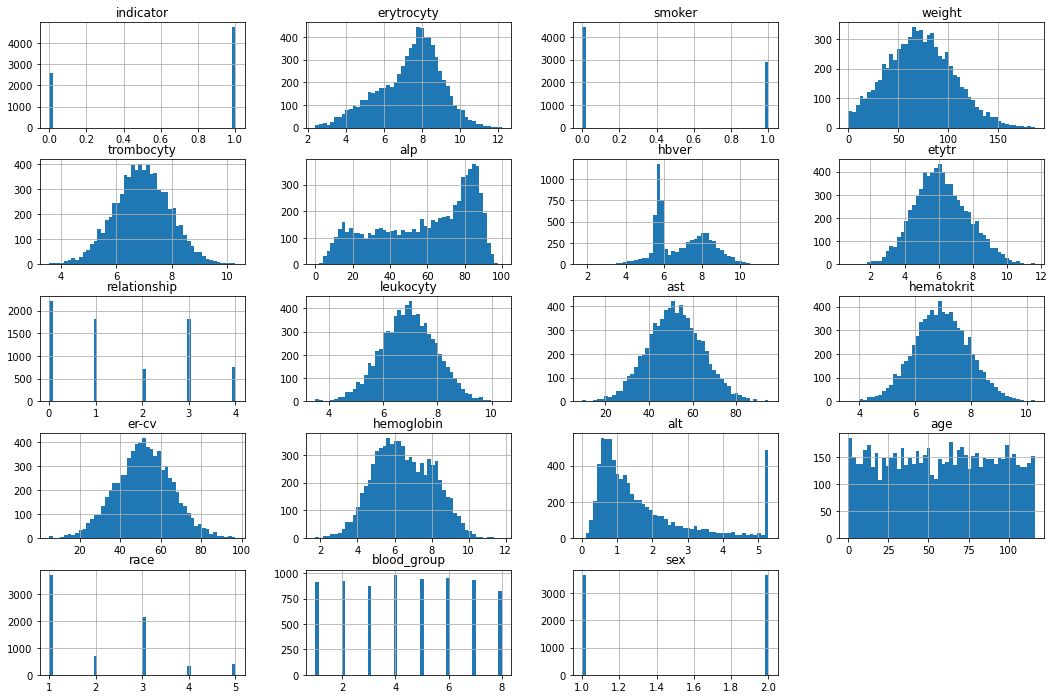

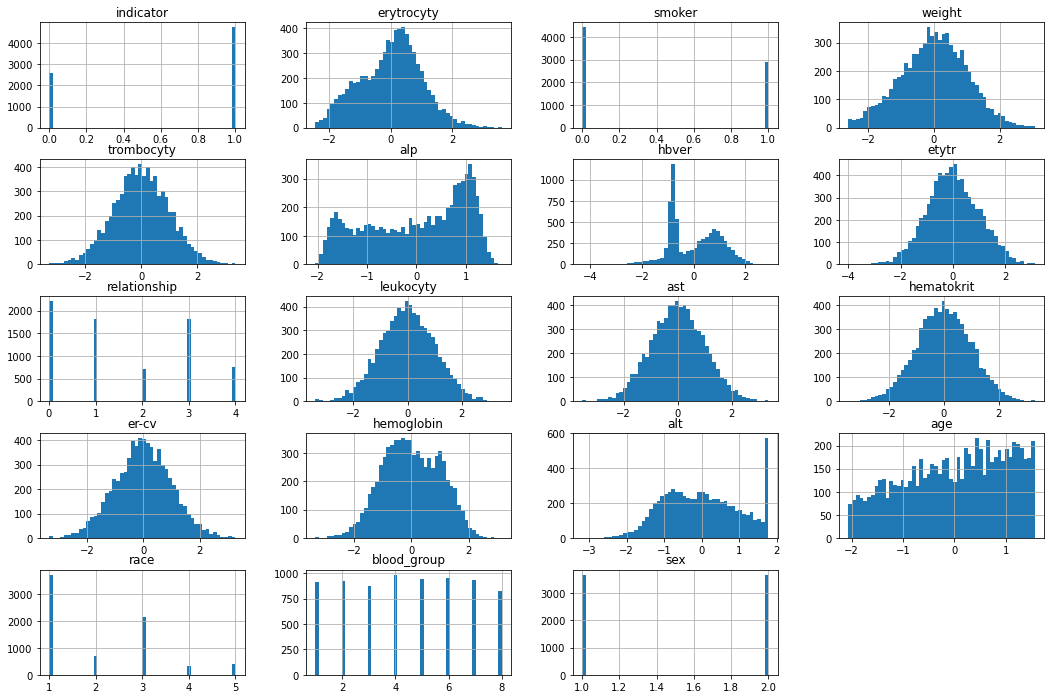

In [271]:
df_train.hist(figsize=(18, 12), bins=50)
transformer = PowerTransformer(method="yeo-johnson")
idx = [i for i in df_train.columns if i in ["erytrocyty", "weight", "trombocyty", "alp", "hbver", "etytr", "leukocyty", "ast", "hematokrit", "er-cv", "hemoglobin", "alt", "age"]]
df_train[idx] = transformer.fit_transform(df_train[idx])
df_train.hist(figsize=(18, 12), bins=50)

Keďže atribúty máme v rôznych intervaloch, môže sa stať, že pri trénovaní by mal jeden z nich bezdôvodne väčší dopad len kvôli tomu, že jeho hodnoty nadobúdajú väčšie extrémy. To by v konečnom dôsledku mohlo zvýšiť chybovosť celého modelu. Z toho dôvodu sme sa rozhodli preškálovať všetky atribúty do intervalu 0-1.

In [272]:
scaler = MinMaxScaler()

# transform data
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns) 
df_train.tail()

,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,leukocyty,ast,hematokrit,er-cv,hemoglobin,alt,age,race,blood_group,sex
7332,1.0,0.207564,0.0,0.283903,0.596444,0.391440,0.767294,0.707801,0.00,0.386424,0.819443,0.482552,0.537245,0.648217,0.394054,0.740455,0.0,0.714286,0.0
7333,0.0,0.412199,0.0,0.397789,0.563404,0.748865,0.669997,0.775695,0.75,0.468080,0.487135,0.460247,0.339728,0.399941,0.640809,0.727109,0.0,0.142857,0.0
7334,1.0,0.388432,0.0,0.398110,0.444265,0.685887,0.644421,0.501158,0.50,0.509764,0.738077,0.539189,0.627208,0.406526,0.584757,0.199886,0.0,0.000000,1.0
7335,1.0,0.280353,1.0,0.320975,0.627031,0.321378,0.498816,0.500880,0.00,0.289337,0.428908,0.582484,0.582478,0.685885,0.393216,0.764431,0.5,0.285714,0.0
7336,1.0,0.334405,0.0,0.571428,0.236704,0.906808,0.700788,0.545925,0.00,0.791608,0.472694,0.562661,0.322856,0.483091,0.603486,0.674881,0.5,0.285714,1.0


## 3. Výber atribútov pre strojové učenie

Atribúty pre strojové učenie vyberáme z pripraveného a predspracovaného datasetu df_train. Najprv si dataframe vypíšeme, aby sme videli s čím pracujeme.

In [273]:
df_train.head()

,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,leukocyty,ast,hematokrit,er-cv,hemoglobin,alt,age,race,blood_group,sex
0,1.0,0.525972,1.0,0.560160,0.530014,0.332355,0.935861,0.771715,0.75,0.327057,0.416363,0.493373,0.506218,0.692569,0.802736,0.076770,0.0,0.571429,1.0
1,0.0,0.573989,0.0,0.355634,0.124524,0.271726,0.393065,0.600524,0.75,0.458407,0.615951,0.496707,0.528795,0.304465,0.907845,0.115710,1.0,0.000000,1.0
2,0.0,0.339484,0.0,0.578251,0.713134,0.854665,0.312626,0.405735,0.75,0.485512,0.506085,0.477993,0.616480,0.492774,0.588161,0.708651,0.0,0.857143,0.0
3,0.0,0.405780,0.0,0.680152,0.838462,0.601036,0.294301,0.421388,0.25,0.466905,0.338063,0.570208,0.795538,0.384728,0.648113,0.606638,0.0,0.000000,1.0
4,1.0,0.327493,0.0,0.260800,0.359105,0.524013,0.528985,0.502173,0.25,0.641060,0.360808,0.617246,0.596337,0.352767,0.397708,0.358008,0.0,0.285714,1.0


Na základe výpisu vieme, kde sa ktorý atribút nachádza. Naše vstupné atribúty do feature selection sú všetky stĺpce okrem atribútu "indicator", ktorý sa nachádza v 0tom stĺpci. Z datasetu si teda môžeme vytiahnuť X - atribúty, z ktorých vyberáreme také, na ktorých najviac závisí y - "indicator", čiže náš cieľový atribút.

In [274]:
X = df_train.iloc[:, 1:-1]  
y = df_train.iloc[:,0]

Pre lepšiu vizualizáciu závislostí medzi jednotlivými atribútmi si pomocu korelačnej matice a heatmapy zobrazíme vzťahy. Konkrétne nás zaujíma len riadok "indicator".

<AxesSubplot:>

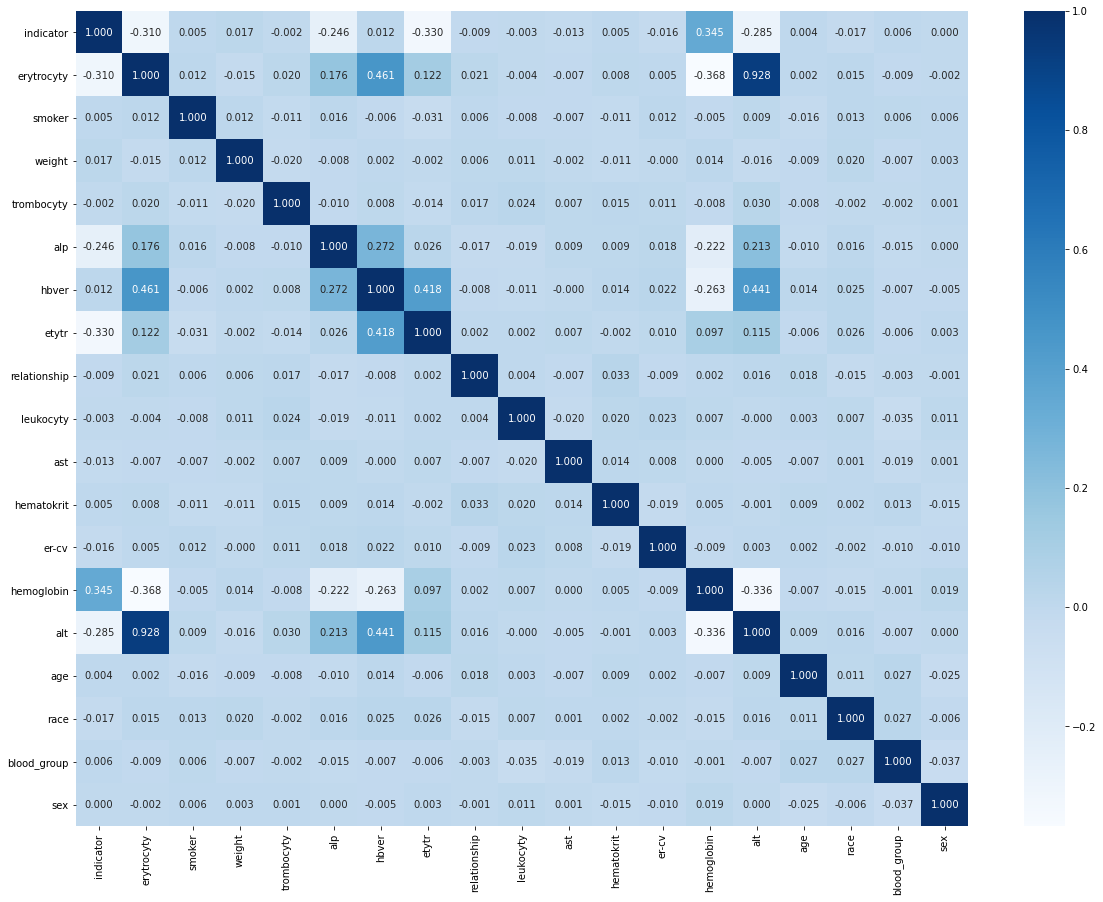

In [275]:
corrmat = df_train.corr()
top_corr_features = corrmat.index
fig, ax = plt.subplots(figsize=(20,15))

sns.heatmap(df_train[top_corr_features].corr(), annot=True, fmt = ".3f", cmap = "Blues")

Prejdeme k samotnému "feature selection". Ako metódu pre feature selection sme zvolili SelectKBest() z hľadiska jednoduchosti a vhodnosti pre daný prípad - "SelectKBest can be used to select those features that have the strongest relationship with the output variable".

Ako štatistickú testovaciu metódu sme zvolili chi_squared, pre vybranie 10tich najlepších atribútov. Následne sme si výsledok vypísali.

In [276]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Attribute','Score']
print(featureScores.nlargest(10,'Score'))

       Attribute      Score
4            alp  57.350180
0     erytrocyty  47.484002
12    hemoglobin  40.170711
13           alt  37.825094
6          etytr  28.209683
15          race   0.785550
7   relationship   0.181590
2         weight   0.144802
1         smoker   0.095300
11         er-cv   0.088018


V 10tich najlepších atribútoch sa však nachádzajú aj také ktoré majú zanedbateľnú závislosť tj. Score < 1. Tieto hodnoty nebudeme uvažovať, preto môžeme spraviť feature selection ešte raz, tentokrát len pre 5 najlepších.

In [277]:
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Attribute','Score']
print(featureScores.nlargest(5,'Score'))

     Attribute      Score
4          alp  57.350180
0   erytrocyty  47.484002
12  hemoglobin  40.170711
13         alt  37.825094
6        etytr  28.209683


## 4. Replikovateľnosť predspracovania

In [278]:
def merge_dataframes(df_profiles, df_labor):
    df_profiles = df_profiles.drop_duplicates(subset=["name"], keep=False)
    df_profiles["age"] = (pd.to_datetime(dt.date.today()) - pd.to_datetime(df_profiles.birthdate)).dt.days / 365
    df_merged = pd.merge(df_labor, df_profiles[["age", "race", "blood_group", "sex", "name"]], how="inner", on="name")
    wanted = ["indicator", "erytrocyty", "smoker", "weight", "trombocyty", "alp", "hbver", "etytr", "relationship", "leukocyty", "ast", "hematokrit", "er-cv", "hemoglobin", "alt", "age", "race", "blood_group", "sex"]
    df_merged = df_merged[wanted]
    return df_merged

In [279]:
def get_unique_num_attributes(df_merged):
    df_merged.smoker = df_merged.smoker.replace({"Y": 1, "N": 0, "yes": 1, "no": 0})
    df_merged.relationship = df_merged.relationship.replace({"single": 0, "nop": 0, "married": 1, "separated": 2, "divoced": 3, "widowed": 4})
    df_merged.race = df_merged.race.replace({"white": 1, "White": 1, "Asian": 2, "black": 3, "Black": 3, "blsck": 3, "Indian": 4, "Hawaiian": 5})
    df_merged.blood_group = df_merged.blood_group.replace({"O-": -1, "O+": 1, "A-": -2, "A+": 2, "B-": -3, "B+": 3, "AB-": -4, "AB+": 4})
    df_merged.sex = df_merged.sex.replace({"M": 1, "F": 2})
    df_merged = df_merged.drop_duplicates()
    return df_merged


In [280]:
def impute_by_mean(df_merged):
    mean_replace = ["erytrocyty", "hbver", "etytr"]
    means = df_merged[mean_replace].mean()
    df_merged[mean_replace] = df_merged[mean_replace].fillna(value=means)
    return df_merged

In [281]:
def impute_by_median(df_merged):
    median_replace = ["leukocyty", "er-cv", "hemoglobin"]
    medians = df_merged[median_replace].median()
    df_merged[median_replace] = df_merged[median_replace].fillna(value=medians)
    return df_merged

In [282]:
def impute_by_knn(df_merged):
    knn = KNNImputer(n_neighbors=5)
    columns = df_merged.columns
    df_merged = pd.DataFrame(knn.fit_transform(df_merged))
    df_merged.columns = columns
    return df_merged

In [283]:
def remove_outliers(df_merged):
    mean = df_merged.erytrocyty.mean()
    std = df_merged.erytrocyty.std()
    cut = std * 3
    low_limit = mean - cut
    up_limit = mean + cut 
    df_merged = df_merged[(df_merged.erytrocyty > low_limit) & (df_merged.erytrocyty < up_limit)]
    return df_merged

In [284]:
def replace_outliers(df_merged):
    for column in df_merged:
        q1 = df_merged[column].quantile(0.20)
        q3 = df_merged[column].quantile(0.80)
        cut = (q3 - q1) * 1.5
        minimum_check = q1 - cut
        maximum_check = q3 + cut
        df_merged[column] = np.where(df_merged[column] < minimum_check, minimum_check, df_merged[column])
        df_merged[column] = np.where(df_merged[column] > maximum_check, maximum_check, df_merged[column])
    return df_merged

In [285]:
def preprocess_data(df_merged):
    df_train, df_test = train_test_split(df_merged, test_size=0.2)
    scaler = MinMaxScaler()
    df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns) 
    transformer = PowerTransformer(method="yeo-johnson")
    columns = ["erytrocyty", "weight", "trombocyty", "alp", "hbver", "etytr", "leukocyty", "ast", "hematokrit", "er-cv", "hemoglobin", "alt", "age"]
    df_train[columns] = transformer.fit_transform(df_train[columns])
    return df_train, df_test